# Austin Nightlife

In [27]:
from sklearn import metrics, preprocessing
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import requests
import folium
import random

mpl.style.use('seaborn-muted')
client_id = 'GGIL3FS30MVYZXY0LH1243H5A2QNHDGQJD2P3YHH1ELMLLVP'
client_secret = 'WHZXQ1O5I351N0VLZUG4GYNC53F4N3RWFSR3JYK2LKL2XV24'
version = '20201120'  # Date this code was developed

## Get List of Austin Neighborhoods
I manually compiled a list of Austin Neighborhoods at [this link](https://raw.githubusercontent.com/bryandeagle/Coursera_Capstone/main/austin.csv). This is a CSV file containing neighborhoods with longitudes and latitudes. It was compiled from the Wikipedia page [Category:Neighborhoods in Austin, Texas](https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Austin,_Texas).

In [2]:
df = pd.read_csv('https://bit.ly/3kUiOy9')
df.head()

,Neighborhood,Latitude,Longitude
0,Allandale,30.342000,-97.744000
1,Anderson Mill,30.455000,-97.809167
2,Barton Hills,30.258056,-97.781111
3,Blackland,30.280991,-97.722097
4,Bouldin Creek,30.249344,-97.755253


## Get Proximity to Nightlife Spots, Mexican Restaurants, and Food Trucks

In [9]:
def venue_count_dummy(row, category):
    """ Dummy of venue count to avoid exceeding quota during debug """
    return random.randint(0, 50)

def venue_count(row, category):
    """ Returns count of venues within a 1 km radius of a location """
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}' \
          '&v={}&categoryId={}&radius=1000&limit=50'.format(client_id, client_secret, row[0], row[1], \
                                                            version, category)
    results = requests.get(url).json()
    if results['meta']['code'] == '429':
        raise ValueError('Foursquare Quota Exceeded')
    return int(results['response']['totalResults'])

# Foursquare categories
cats = {'nightlife': '4d4b7105d754a06376d81259',
        'foodtruck': '4bf58dd8d48988d1cb941735'}

# Apply venue_count function to dataframe
df['Nightlife'] = df[['Latitude', 'Longitude']].apply(venue_count_dummy, args=(cats['nightlife'],), axis=1)
df['Food Truck'] = df[['Latitude', 'Longitude']].apply(venue_count_dummy, args=(cats['foodtruck'],), axis=1)

# Drop neighborhoods with no nightlife
df.drop(df[df['Nightlife'] == 0 ].index, inplace=True)

# Calculate and sort byFoodtruck-to-Bar Ratio (FBR)
df['FBR'] = df['Food Truck'] / df['Nightlife']
df.sort_values('FBR', inplace=True)
df.head()  # Display results

,Neighborhood,Latitude,Longitude,Nightlife,Food Truck,FBR
43,Westgate,30.225000,-97.797222,17,0,0.000000
39,Swedish Hill,30.275000,-97.729444,41,2,0.048780
8,Bryker Woods,30.304830,-97.751800,18,1,0.055556
19,Galindo,30.339917,-97.730856,34,2,0.058824
23,Montopolis,30.258056,-97.781111,39,7,0.179487


### Plot Neighborhoods with Lowest Bar-to-Foodtruck Ratio

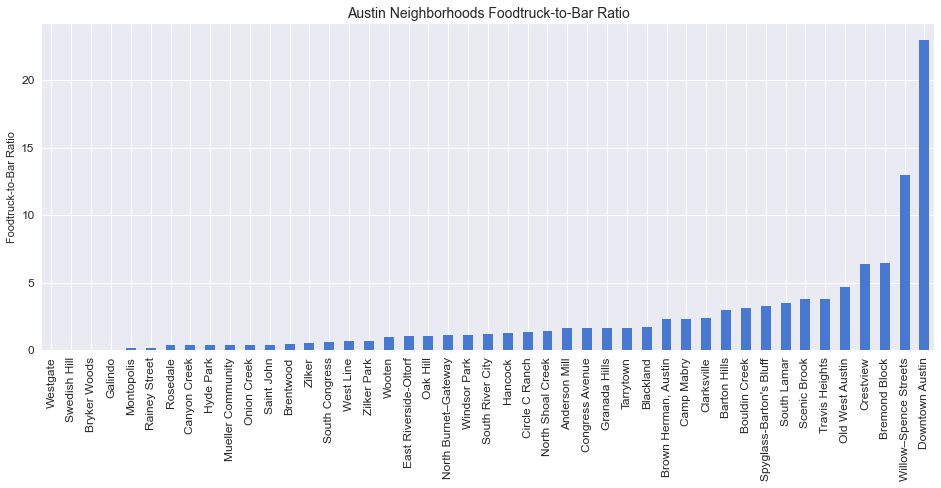

In [29]:
# Plot neighborhoods in descendingn order by BFR
df.plot(kind='bar',
        x='Neighborhood', xlabel='',
        y='FBR', ylabel='Foodtruck-to-Bar Ratio',
        figsize=(16, 6),
        fontsize=12,
        legend=None)
plt.title('Austin Neighborhoods Foodtruck-to-Bar Ratio', fontsize=14)
plt.show()

## Map Austin Neighborhoods

In [5]:
# Get Longitude and Latitude of Austin, Texas
location = Nominatim(user_agent='explorer').geocode('Austin, TX')
lat, lng = location.latitude, location.longitude

# Create map object
venues_map = folium.Map(location=[lat, lng], zoom_start=14)

# add the nightlife spots as blue circle markers
for lat, lng, name, pop in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Food Truck']):
    folium.CircleMarker(
        [lat, lng],
        radius=20 * pop,
        popup=name,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

### Example DBSCAN

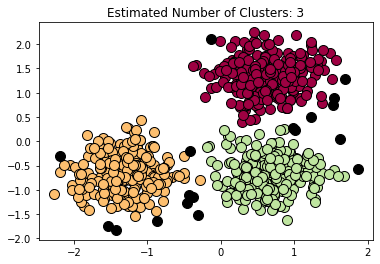

In [64]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)



# Black removed and is used for noise instead
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:   # Black used for noise
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

plt.title('Estimated Number of Clusters: %d' % n_clusters_)
plt.show()

----

### Compute DBSCAN

In [61]:
mms = preprocessing.MinMaxScaler()
lat_lng = mms.fit_transform(df[['Latitude', 'Longitude']])
db = DBSCAN(eps=0.1, min_samples=3).fit(lat_lng)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Number of Clusters: {}'.format(n_clusters))

Number of Clusters: 3


### Plot the Result

In [62]:
# Creat map object
venues_map = folium.Map(location=[lat, lng], zoom_start=14)

# Create colors for unique labels
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(labels)))]

colors = ['#ff0000', '#00ff00', '#0000ff']

# add the nightlife spots as blue circle markers
for lat, lng, name, pop, label in zip(df['Latitude'], df['Longitude'], df['Name'], df['Popularity'], labels):
    
    col = colors[label] if label >= 0 else [0, 0, 0, 1]
    
    folium.CircleMarker(
        [lat, lng],
        radius=20 * pop,
        popup=name,
        fill=True,
        color=col,
        fill_color=col,
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map